Following up on the conversation with Jason:
- if we keep raising the 1/f aperiodic component, eventually it will swamp the oscillation
- does the power add linearly to the noise component? does fooof "do the right thing" in retrieving that original power?

In [183]:
import numpy as np
from neurodsp import spectral, sim
from scipy import signal
from fooof import FOOOFGroup

%matplotlib inline
import matplotlib.pyplot as plt

In [184]:
# simulate the signals
n_seconds, fs = 1200, 1000
noise = sim.aperiodic.sim_synaptic_noise(n_seconds, fs, tau_d=1)
noise = noise-noise.mean()
osc = sim.periodic.sim_oscillator(n_seconds, fs, freq=10)
f_axis, psd_noise = spectral.compute_spectrum(noise, fs)
f_axis, psd_osc = spectral.compute_spectrum(osc, fs)

In [185]:
# vary noise amplitude and compute PSD
noise_amp = 10**np.arange(0,2,0.1)
psd = np.zeros((int(fs/2)+1,noise_amp.shape[0]))
scv = np.zeros((int(fs/2)+1,noise_amp.shape[0]))
for i, na in enumerate(noise_amp):
    sig = noise*na+osc
    f_axis, psd[:,i] = spectral.compute_spectrum(noise*na+osc, fs)
    f_axis, scv[:,i] = spectral.compute_scv(noise*na+osc, fs)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2923: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


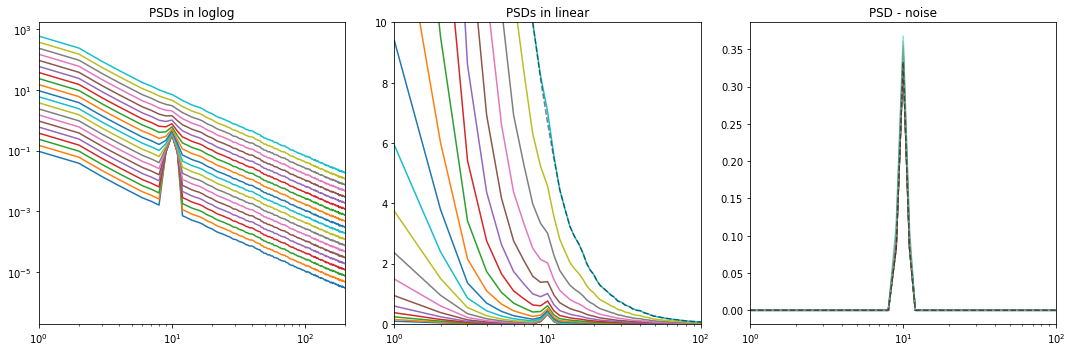

In [186]:
plt.figure(figsize=(15,5))

# plot in loglog
plt.subplot(1,3,1)
plt.loglog(f_axis, psd)
plt.xlim([0,200])
plt.title('PSDs in loglog')

# plot in linear power
plt.subplot(1,3,2)
plt.semilogx(f_axis, psd)
plt.semilogx(f_axis, psd_noise*noise_amp[-1]**2, '--k', alpha=0.5)
plt.xlim([1,100]); plt.ylim([0,10])
plt.title('PSDs in linear')

plt.subplot(1,3,3)
for i, na in enumerate(noise_amp):
    plt.semilogx(f_axis, psd[:,i]-psd_noise*na**2, alpha=0.5)

plt.semilogx(f_axis, psd_osc, 'k--', alpha=0.5)
plt.xlim([1,100])
plt.title('PSD - noise')

plt.tight_layout()

### Powers linearly sum
It's very hard to tell by looking at the plots to say that the oscillation is still present, even in the linear power case. In the middle plot, the dashed line is the noise PSD at the highest power, and you can see that it *seems* like it follows the highest curve exactly, which would imply that the noise completely swamped the oscillation.


However, the powers do add linearly (this HAS to be the case), i.e., there is still power contributed by the oscillation above the 1/f. It comes through when you plot the difference between the signal PSD (with the osc) and the noise PSD (right plot). The dashed line is the oscillation PSD, which is just a peak at the osc frequency. The colored lines are the remainder (psd-psd_noise), which shows that there is equal power in all conditions at the osc freq - the power that we put in.

I think this is how the math should come out, but you definitely scared me for a sec. The question is whether FOOOF will detect this, as it's fitting in log power?

Running FOOOFGroup across 20 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Peak parameters -------------
[[10.0431175   2.75482185  1.93717091  0.        ]
 [10.04681506  2.51706573  1.91801184  1.        ]
 [10.05101919  2.28114556  1.89495422  2.        ]
 [10.05580094  2.04772104  1.86696868  3.        ]
 [10.06105466  1.81810664  1.83283303  4.        ]
 [10.06660289  1.59387047  1.79136501  5.        ]
 [10.07239647  1.37721672  1.74154781  6.        ]
 [10.07752017  1.16981123  1.68195267  7.        ]
 [10.08160876  0.9747122   1.61424869  8.        ]
 [10.08414941  0.79441789  1.542113    9.        ]
 [10.08526291  0.63080785  1.47023782 10.        ]
 [10.08303786  0.49227815  1.4

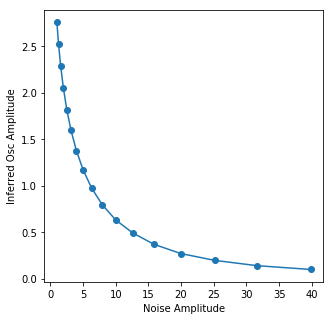

In [187]:
fg = FOOOFGroup(max_n_peaks=1, peak_threshold=0.1)
fg.fit(f_axis, psd.T, [3,100])
print('Peak parameters -------------')
print(fg.get_all_data('peak_params'))
print('\nAperiodic parameters -------------')
print(fg.get_all_data('aperiodic_params'))

pk_params = fg.get_all_data('peak_params')
plt.figure(figsize=(5,5))
plt.plot(noise_amp[pk_params[:,-1].astype(int)], pk_params[:,1], 'o-')
plt.xlabel('Noise Amplitude');plt.ylabel('Inferred Osc Amplitude');

# FOOOF fits in log-power
From the above, you can see that the fitted oscillation amplitude (second column) steadily decreases. Somehow, though, it's still finding the correct frequency. The aperiodic parameters, on the other hand, are (more or less) fine, since the exponent fit doesn't really change, and the offset increases as expected.

The plot demonstrates your point, Jason: that the aperiodic and oscillation estimates are correlated, even though the aperiodic background is independently changing.

So this is a little problematic, since the reported oscillatory power is not technically what is actually over and above the 1/f, as it should be consistent with difference plot above (3rd plot). My guess is due to the reporting in log-power.

I think we can fix this by extracting the power by subtracting the fitted background from the original, but in linear power, assuming the fit is more or less okay.

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Remaining Power at 10Hz----------
[0.33381443 0.33394735 0.33411732 0.33433413 0.33461004 0.33496034
 0.33540535 0.33596501 0.33667759 0.33760259 0.33882021 0.34081687
 0.34326042 0.34682666 0.35277701 0.36051601 0.37200539 0.35652009
 0.37493911 0.40278256]


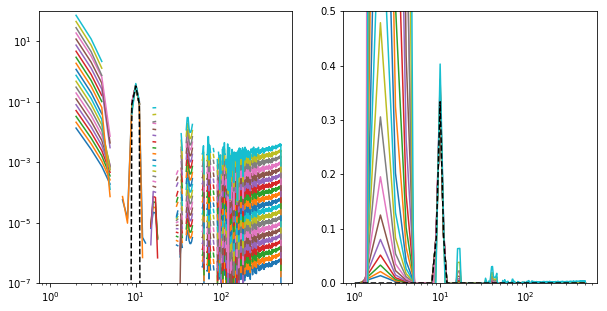

In [188]:
# create aperiodic using fooof fits
ap = fg.get_all_data('aperiodic_params')
ff_noise = (10**ap[:,0][None,:])/f_axis[:,None]**ap[:,1][None,:]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(f_axis, psd-ff_noise)
plt.loglog(f_axis, psd_osc, '--k')
plt.ylim([1e-7, 100])

plt.subplot(1,2,2)
plt.semilogx(f_axis, psd-ff_noise)
plt.semilogx(f_axis, psd_osc, '--k')
plt.ylim([1e-7, 0.5])

print('Remaining Power at 10Hz----------')
print(psd[10,:]-ff_noise[10,:])

### Background fit is (kinda) good enough to retrieve the oscillation in linear power
Plotted above is the difference between the signal PSDs and the fitted background, in log power (left) and linear power(right). You can see that it does retrieve the correct oscillation power at 10Hz (around 0.33), which is good. However, the slight error in fit will be really amplified at low frequencies. Though I think this is due to the fact that I used a synaptic noise instead of a pure 1/f noise, so it plateaus and introduces a systematic error at ~1Hz, so I wouldn't worry **too much** about that. At higher frequencies, though, it looks like the fit error is idiosyncratic, and will just happen by chance, esp if the PSD is not smooth.

Which brings us to the question, when an oscillation is barely above the noise floor of the aperiodic background, can we ever be sure that there's an oscillation? (That's more or less a rhetorical question.) How do we REALLY define the oscillation?

Text(0.5,1,'SCV')

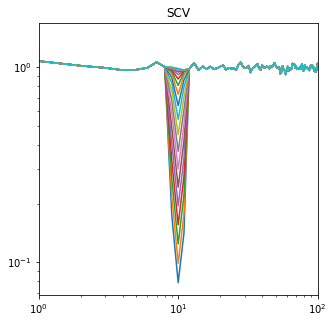

In [191]:
plt.figure(figsize=(5,5))
plt.loglog(f_axis, scv)
plt.xlim([1,100])
plt.title('SCV')

SCV is a little sensitive, at least when plotted in loglog, because it looks for a difference in the distribution as measured by the scaled variance. Maybe actually looking for distribution difference via KS test would do better, will look into that later.